In [13]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

# Quadratic Unconstrained Binary Optimization (QUBO)

Solving combinatorial optimization problems using quantum computing is
one of those promising applications for the near term. But, why are
combinatorial optimization problems even important? We care about them
because, in fields such as logistics, finance, and engineering, there
exist useful applications that can be translated into combinatorial
optimization problems. But useful applications are not enough to justify
the use of quantum devices. It is here where the second ingredient comes
in---many combinatorial optimization problems are difficult to solve!
Finding good solutions (classically) for large instances of them
requires an enormous amount of computational resources and time 😮‍💨.

In this demo, we will be using the quantum approximate optimization
algorithm (QAOA) and quantum annealing (QA) to solve a combinatorial
optimization problem. First, we show how to translate combinatorial
optimization problems into the quadratic unconstrained binary
optimization (QUBO) formulation. In the first part of this notebook, we
will show how to encode the Knapsack problem as a target Hamiltonian and
solve it using the optimization-free version of QAOA and QA on D-Wave
Advantage quantum annealer.

![](../_static/demonstration_assets/QUBO/items_QUBO.png){.align-center
width="50.0%"}


# Combinatorial Optimization Problems

Combinatorial optimization problems involve finding the best way to
arrange a set of objects or values to achieve a specific goal. The word
'combinatorial' refers to the fact that we are dealing with combinations
of objects, while 'optimization' means that we are trying to find the
best possible arrangement of them.

Let's start with a basic example. Imagine we have 5 items ⚽️, 💻, 📸,
📚, and 🎸 and we would love to bring all of them with us.
Unfortunately, our knapsack does not fit all of them 😔. So we need to
find the best way to bring the most important items with us.

This is an example of the infamous *Knapsack Problem.* From our problem
statement, we know that we need to maximize the value of the most
important items. So we need to assign a value based on the importance
the items have to us:


In [14]:
items_values = {"⚽️": 8, "💻": 47, "📸": 10, "📚": 5, "🎸": 16}
values_list = [8, 47, 10, 5, 16]

Additionally, we know that we the knapsack has limited space. For
simplicity, let's assume there is a limit to the weight it can hold. So
we need to assign an estimate of the weight of each item:


In [15]:
items_weight = {"⚽️": 3, "💻": 11, "📸": 14, "📚": 19, "🎸": 5}
weights_list = [3, 11, 14, 19, 5]

Finally, we need to know the maximum weight we can bring in the
knapsack:


In [ ]:
max_nodes = 26

Now we have well-defined optimization problem to work with. Let's start
with the easiest way to solve it, i.e., by trying all possible
combinations of the items. But the number of combinations is equal to
$2^n$ where $n$ is the number of items. Why is this the case? For each
item, we have two options---"1" if we bring the item and "0" otherwise.
With 2 options for each item and 5 items to choose from, we have
$2 \cdot 2 \cdot 2 \cdot 2 \cdot 2 = 2^5 = 32$ combinations in our case.
For each of these cases, we calculate the sum of the values and the sum
of the weights, selecting the one that fulfills the maximum weight
constraint and has the largest sum of values (this is the optimization
step). Now, let\'s write some code to solve the Knapsack problem with
this brute-force method!


In [ ]:
import numpy as np

def sum_weight(bitstring):
    weight = 0
    for bit in bitstring:
        weight += 1 if bit == "1" else 0
    return weight


def sum_values(bitstring, items_value):
    value = 0
    for n, i in enumerate(items_value):
        if bitstring[n] == "1":
            value += i
    return value

items = list(items_values.keys())
n_items = len(items)
combinations = {}
max_value = 0
for case_i in range(2**n_items):  # all possible options
    combinations[case_i] = {}
    bitstring = np.binary_repr(
        case_i, n_items
    )  # bitstring representation of a possible combination, e.g, "01100" in our problem means bringing (-💻📸--)
    combinations[case_i]["items"] = [items[n] for n, i in enumerate(bitstring) if i == "1"]
    combinations[case_i]["value"] = sum_values(bitstring, values_list)
    combinations[case_i]["weight"] = sum_values(bitstring, weights_list)
    # save the information of the optimal solution (the one that maximizes the value while respecting the maximum weight)
    if (
        combinations[case_i]["value"] > max_value
        and combinations[case_i]["weight"] <= max_nodes
    ):
        max_value = combinations[case_i]["value"]
        optimal_solution = {
            "items": combinations[case_i]["items"],
            "value": combinations[case_i]["value"],
            "weight": combinations[case_i]["weight"],
        }


print(
    f"The best combination is {optimal_solution['items']} with a total value: {optimal_solution['value']} and total weight {optimal_solution['weight']} "
)

The best combination is ['⚽️'] with a total value: 8 and total weight 3 


That was easy, right? But what if we have larger cases like 10, 50, or
100? Just to see how this scales, suppose it takes 1 ns to try one case.


In [18]:
def print_time_to_solution(n, time_single_case):
    """
    Compute and print the time required to test all 2^n combinations,
    converting the result to seconds, days, or years based on its magnitude.

    Parameters:
        n (int): Number of variables/items.
        time_single_case (float): Time to compute a single case in seconds.
    """
    # Conversion constants
    sec_day = 3600 * 24
    sec_year = sec_day * 365
    
    # Compute total time in seconds
    total_time_sec = time_single_case * (2 ** n)
    
    # Select appropriate unit for presentation
    if total_time_sec < sec_day:
        time_str = f"{total_time_sec:.2e} seconds"
    elif total_time_sec < sec_year:
        time_in_days = total_time_sec / sec_day
        time_str = f"{time_in_days:.2f} days"
    else:
        time_in_years = total_time_sec / sec_year
        time_str = f"{time_in_years:.2f} years"
        
    print(f"- For {n} regions (about 2^{n} cases), we need approximately {time_str} to compute classically.")

# Example usage:
time_per_case = 1e-9  # Time for a single case in seconds

print_time_to_solution(25, time_per_case)
print_time_to_solution(50, time_per_case)
print_time_to_solution(100, time_per_case)


- For 25 regions (about 2^25 cases), we need approximately 3.36e-02 seconds to compute classically.
- For 50 regions (about 2^50 cases), we need approximately 13.03 days to compute classically.
- For 100 regions (about 2^100 cases), we need approximately 40196936841331.48 years to compute classically.


Guess we don't have the time to try all the possible solutions for 100
items 😅! Thankfully, we don\'t need to --- there are algorithms to find
good solutions to combinatorial optimization problems, and maybe one day
we will show that one of these algorithms is quantum. So let's continue
with our quest 🫡.

Our next step is to represent our problem mathematically. First, we
represent our items by binary variables $x_i$ that take the value $1$ if
we bring the $i$-th item and $0$ otherwise. Next, we know that we want
to **maximize** the value of the items carried, so let's create a
function $f(\mathrm{x})$ with these characteristics. To do so, we assign
the variables $x_i$ to each of the items
$\mathrm{x} = \{x_0:⚽️ , x_1:💻, x_2:📸, x_3:📚, x_4:🎸\},$ multiply
each variable by the corresponding item value, and define a function
that calculates the weighted sum value of the item:

$$\max_x f(\mathrm{x}) = \max_x \left(8x_0 + 47x_1 + 10x_2 + 5x_3 + 16x_4\right) \tag{1}$$

This function, called the `objective function`, represents the value of
the items we can transport. Usually, solvers [minimize
functions](https://en.wikipedia.org/wiki/Mathematical_optimization), so
a simple trick in our case is to minimize the negative of our function
(which ends up being maximizing our original function 🤪)

$$\min_x -(8x_0 + 47x_1 + 10x_2 + 5x_3 + 16x_4 ) \tag{2}$$

We can write our equation above using the general form of the [QUBO
representation](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization),
i.e., using an upper triangular matrix
$Q \in \mathbb{R}^{n \  \mathrm{x} \ n}:$

$$\min_x \mathrm{x}^TQ \mathrm{x} = \min_x \left(\sum_i \sum_{j\ge i} Q_{ij} x_i x_j\right) = \min_x \left(\sum_i Q_{ii} x_i + \sum_i\sum_{j>i} Q_{ij}x_i x_j\right) \tag{3}$$

where $\mathrm{x}$ is a vector representing the items of our problem.
Note that $x_i x_i = x_i$ for binary variables. Let\'s look at an
example of how to calculate the $\mathrm{x}^TQ \mathrm{x}$ above:


In [31]:
Q = np.load('results/full_matrix.npy')
# x_opt = np.array(
#     [[1 if i in optimal_solution["items"] else 0] for i in items_values.keys()]
# )  # Optimal solution.
# opt_str = "".join(str(i[0]) for i in x_opt)
# min_cost = (x_opt.T @ Q @ x_opt)[0, 0]  # using Equation 3 above
print(f"Q={Q}")
# print(f"The minimum cost is  {min_cost}")
print(f"Shape of Q: {Q.shape}")

Q=[[190.2905     115.4170225   25.75301871 115.4170225   70.0039628
   15.61999543  25.75301871  15.61999543   3.48529208]
 [106.92955512 176.297032   106.92955512  64.85605361 106.92955512
   64.85605361  14.47134163  23.85920876  14.47134163]
 [ 24.17177101 108.33036194 178.606572    14.66092022  65.7056859
  108.33036194   3.27129348  14.66092022  24.17177101]
 [ 71.32455321  43.26052831   9.65272861 117.594308    71.32455321
   15.91465898  71.32455321  43.26052831   9.65272861]
 [ 46.37007932  76.4513361   46.37007932  76.4513361  126.046944
   76.4513361   46.37007932  76.4513361   46.37007932]
 [ 12.03240917  53.92551665  88.90814633  19.83808893  88.90814633
  146.584752    12.03240917  53.92551665  88.90814633]
 [ 18.81672058  11.41291795   2.54656621  84.33069099  51.14914964
   11.41291795 139.037804    84.33069099  18.81672058]
 [ 11.08882733  18.28238549  11.08882733  49.69667626  81.93596723
   49.69667626  81.93596723 135.089572    81.93596723]
 [  2.60106461  11.6571628

But just with this function, we cannot solve the problem. We also need
the weight restriction. Based on our variables, the weight list
(items_weight = {"⚽️": $3$, "💻": $11$, "📸": $14$, "📚": $19,$ "🎸":
$5$}), and the knapsack maximum weight (maximum_weight $W = 26$), we can
construct our constraint

$$3x_0 + 11x_1 + 14x_2 + 19x_3 + 5x_4 \le 26$$

Here comes a crucial step in the solution of the problem: we need to
find a way to combine our *objective function* with this *inequality
constraint*. One common method is to include the constraint as a
**penalty** term in the objective function. This penalty term should be
zero when the total weight of the items is less or equal to 26 and large
otherwise. So to make them zero in the range of validity of the
constraint, the usual approach is to use *slack variables*. There is an
alternative method that has shown to perform better, called [unbalanced
penalization](https://arxiv.org/pdf/2211.13914.pdf) , but we present
this method later 😉.

The slack variable is an auxiliary variable that allows us to convert
inequality constraints into equality constraints. The slack variable $S$
represents the amount by which the left-hand side of the inequality
falls short of the right-hand side. If the left-hand side is less than
the right-hand side, then $S$ will be positive and equal to the
difference between the two sides. In our case

$$3x_0 + 11x_1 + 14x_2 + 19x_3 + 5x_4 + S = 26\tag{4}$$

where $0 \le S \le 26.$ But let's take this slowly because we can get
lost here, so let's see this with some examples:

-   Imagine this case. No item is selected {$x_0$: $0$, $x_1$: $0$,
    $x_2:$ $0,$ $x_3$: $0,$ $x_4:$ $0$}, so the overall weight is zero
    (a valid solution) and the equality constraint Eq.(4) must be
    fulfilled. So we select our slack variable to be 26.
-   Now, what if we bring ⚽️ and 📚 {$x_0$: $1$, $x_1$: $0$, $x_2$: $0$,
    $x_3:$ $1,$
    $x_4:`0}. In this case, the overall weight is :math:`3 + 19 = 22$ (a
    valid solution) and the equality constraint is fulfilled if
    $22 + S = 26 \rightarrow S = 4.$
-   Finally, what if we try to bring all the items {$x_0$: $1$, $x_1$:
    $1$, $x_2:$ $1,$ $x_3$: $1,$ $x_4:$ $1$}, the total weight, in this
    case, is $3+11+14+19+5=52$ (not a valid solution), to fulfill the
    constraint, we need $52 + S = 26 \rightarrow S=-26$ but the slack
    variable is in the range $(0,26)$ in our definition, so, in this
    case, there is valid solution for $S.$

Excellent, now we have a way to represent the inequality constraint. Two
further steps are needed. First, the slack variable has to be
represented in binary form so we can cast it as a sum

$$S = \sum_{k=0}^{N-1} 2^k s_k,$$

where $N = \lfloor\log_2(\max S)\rfloor + 1.$ In our case
$N = \lfloor\log_2(26)\rfloor + 1 = 5.$ We need 5 binary variables to
represent the range of our $S$ variable.

$$S = 2^0 s_0 + 2^1 s_1 + 2^2 s_2 + 2^3 s_3 + 2^4 s_4$$

To compact our equation later, let's rename our slack variables by
$s_0=x_5$, $s_1=x_6,$ $s_3=x_7$, $s_4=x_8,$ and $s_5=x_9.$ Then we have

$$S = 1 x_5 + 2 x_6 + 4 x_7 + 8 x_8 + 16 x_9.$$

For example, if we need to represent the second case above (⚽️, 📚),
$S = 4 \rightarrow\{x_5:0, x_6:0,x_7:1,x_8:0, x_9:0\}.$

We are almost done in our quest to represent our problem in such a way
that our quantum computer can manage it. The last step is to add the
penalty term, a usual choice for it is to use a quadratic penalty

$$p(x,s) = \lambda \left(3x_0 + 11x_1 + 14x_2 + 19 x_3 + 5x_4 + x_5 + 2 x_6 + 4x_7 + 8 x_8 + 16 x_9 - 26\right)^2. \tag{5}$$

Note that this is simply the difference between the left- and right-hand
sides of equation $(4).$ With this expression, the condition is
satisfied only when the term inside the parentheses is zero. $\lambda$
is a penalty coefficient that we must tune to make that the constraint
will always be fulfilled.

Now, the objective function can be given by:

$$\min_{x,s} f(x) + p(x,s) = \min_{x,s} -(8x_0 + 47x_1 + 10x_2 + 5x_3 + 16x_4) +$$

$$\lambda \left(3x_0 + 11x_1 + 14x_2 + 19x_3 + 5x_4 + x_5 + 2 x_6 + 4x_7 + 8 x_8 + 16 x_9 - 26\right)^2 \tag{6}$$

or, compacted,

$$\min_{x,s} \left(f(x) + p(x,s) = -\sum_i v_i x_i +\lambda \left(\sum_i w_i x_i - W\right)^2\right), \tag{7}$$

where $v_i$ and $w_i$ are the value and weight of the $i$-th item.
Because of the square in the second term, some $x_i x_i$ terms show up.
We can apply the property $x_i x_i = x_i$ (if
$x_i = 0 \rightarrow x_ix_i = 0\cdot0 = 0$ or
$x_i = 1 \rightarrow x_ix_i = 1\cdot1 = 1$).

The quadratic term on the right-hand side of equation $(7)$ can be
rewritten as

$$\left(\sum_i w_i x_i - C\right)^2 = \left(\sum_i w_i x_i - C\right)\left(\sum_j w_j x_j - C\right)$$

$$= \sum_i \sum_j w_i w_j x_i x_j - 2C \sum_i w_i x_i + C^2$$

$$= 2\sum_i \sum_{j>i} w_i w_j x_i x_j - \sum_i w_i(2C - w_i) x_i + C^2 \tag{8}$$

where $w_i$ represent the weights for the items and $2^k$ for the slack
variables. We can combine equations $(7)$ and $(8)$ to get the terms of
the matrix $Q.$ So we end up with

$$Q_{ij} = 2\lambda w_i w_j,\tag{9}$$

$$Q_{ii} = - v_i  + \lambda w_i(w_i - 2W).\tag{10}$$

The term $\lambda W^2$ is only an offset value that does not affect the
optimization result and can be added after the optimization to represent
the right cost. Let\'s see how it looks like in our particular example.


In [76]:
N = round(np.ceil(np.log2(max_nodes)))  # number of slack variables
weights = list(items_weight.values()) + [2**k for k in range(N)]

QT = np.pad(Q, ((0, N), (0, N)))  # adding the extra slack variables at the end of the Q matrix
n_qubits = len(QT)
lambd = 2  # We choose a lambda parameter enough large for the constraint to always be fulfilled
# Adding the terms for the penalty term
for i in range(len(QT)):
    QT[i, i] += lambd * weights[i] * (weights[i] - 2 * max_nodes)  # Eq. 10
    for j in range(i + 1, len(QT)):
        QT[i, j] += 2 * lambd * weights[i] * weights[j]  # Eq. 9
offset = lambd * max_nodes**2
print(f"Q={QT}")
# optimal string slack string
slack_string = np.binary_repr(max_nodes - optimal_solution["weight"], N)[::-1]
x_opt_slack = np.concatenate(
    (x_opt, np.array([[int(i)] for i in slack_string]))
)  # combining the optimal string and slack string
opt_str_slack = "".join(str(i[0]) for i in x_opt_slack)
cost = (x_opt_slack.T @ QT @ x_opt_slack)[0, 0] + offset  # Optimal cost using equation 3
print(f"Cost:{cost}")

# At this point, we have encoded the problem in a format that we can use to solve it on quantum
# computers. Now it only remains to solve it using quantum algorithms!

IndexError: list index out of range

# QAOA

We use QAOA [\[1\]](https://arxiv.org/pdf/1411.4028.pdf) to find the
solution to our Knapsack Problem ([read this
demo](https://pennylane.ai/qml/demos/tutorial_qaoa_intro) for a more
detailed explanation of the QAOA algorithm). In this case, the cost
Hamiltonian, $H_c(Z),$ obtained from the QUBO formulation is translated
into a parametric unitary gate given by

$$U(H_c, \gamma_i)=e^{-i \gamma_i H_c},\tag{11}$$

$$U(H_c, \gamma_i)=e^{-i \gamma_i \left( \sum_{i<j}^{n-1} J_{ij}Z_iZ_j + \sum_{i}^{n-1} h_iZ_i\right)},$$

where $\gamma_i \in {1,..., p}$ is a set of $p$ parameters to be
optimized, the term $e^{-i\gamma_i J_{ij}Z_iZ_j}$ is implemented in a
quantum circuit using a $RZZ(2\gamma_iJ_{ij})$ gate, and
$e^{-i\gamma_i h_iZ_i}$ using a $RZ(2\gamma_ih_i)$ gate.

The mixer operator applied is

$$U(B, \beta_i)=e^{i \beta_i X},\tag{12}$$

where $\beta_i$ is the second parameter that must be optimized and
$X = \sum_{i=1}^n \sigma_i^x$ with $\sigma_i^x$ the Pauli-$X$ matrix. We
implement Eq. $(12)$ with $R_X(-2\beta_i) = e^{i \beta_i \sigma_x}$
gates applied to each qubit. We repeat this sequence of gates $p$ times.


In [77]:
# -----------------------------   QAOA circuit ------------------------------------
from collections import defaultdict
import pennylane as qml

shots = 5000  # Number of samples used
dev = qml.device("default.qubit", shots=shots)


@qml.qnode(dev)
def qaoa_circuit(gammas, betas, h, J, num_qubits):
    wmax = max(
        np.max(np.abs(list(h.values()))), np.max(np.abs(list(h.values())))
    )  # Normalizing the Hamiltonian is a good idea
    p = len(gammas)
    # Apply the initial layer of Hadamard gates to all qubits
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
    # repeat p layers the circuit shown in Fig. 1
    for layer in range(p):
        # ---------- COST HAMILTONIAN ----------
        for ki, v in h.items():  # single-qubit terms
            qml.RZ(2 * gammas[layer] * v / wmax, wires=ki[0])
        for kij, vij in J.items():  # two-qubit terms
            qml.CNOT(wires=[kij[0], kij[1]])
            qml.RZ(2 * gammas[layer] * vij / wmax, wires=kij[1])
            qml.CNOT(wires=[kij[0], kij[1]])
        # ---------- MIXER HAMILTONIAN ----------
        for i in range(num_qubits):
            qml.RX(-2 * betas[layer], wires=i)
    return qml.sample()


def samples_dict(samples, n_items):
    """Just sorting the outputs in a dictionary"""
    results = defaultdict(int)
    for sample in samples:
        results["".join(str(i) for i in sample)[:n_items]] += 1
    return results

The second thing we must consider is the initialization of the $\beta_i$
and $\gamma_i$ parameters and the subsequent classical optimization of
these parameters. Alternatively, we can think of QAOA as a
Trotterization of the [quantum adiabatic
algorithm](https://openqaoa.entropicalabs.com/parametrization/annealing-parametrization/).
We start in the ground state $|+\rangle ^{\otimes n}$ of the mixer
Hamiltonian $X$ and move to the ground state of the cost Hamiltonian
$H_c$ slowly enough to always be close to the ground state of the
Hamiltonian. How slow? In our case the rate is determined by the number
of layers $p.$ We can adopt this principle and initialize the $\beta_i$
and $\gamma_i$ in this way, moving $\beta_i$ from $1$ to $0$ and
$\gamma_i$ from $0$ to $1.$ With this approach, we can skip the
optimization part in QAOA.


C:\Users\fwilh\AppData\Local\Temp\ipykernel_8260\3297791593.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


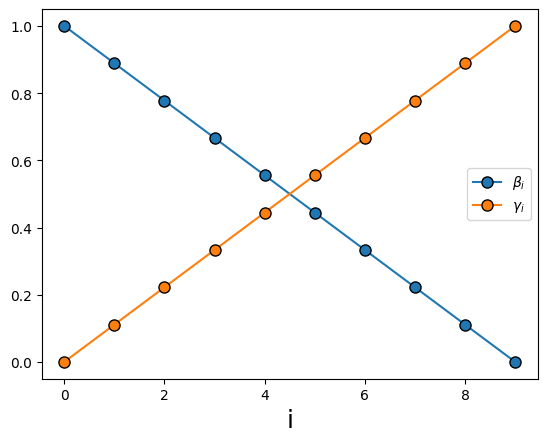

In [22]:
import matplotlib.pyplot as plt
# Annealing schedule for QAOA
betas = np.linspace(0, 1, 10)[::-1]  # Parameters for the mixer Hamiltonian
gammas = np.linspace(0, 1, 10)  # Parameters for the cost Hamiltonian (Our Knapsack problem)

fig, ax = plt.subplots()
ax.plot(betas, label=r"$\beta_i$", marker="o", markersize=8, markeredgecolor="black")
ax.plot(gammas, label=r"$\gamma_i$", marker="o", markersize=8, markeredgecolor="black")
ax.set_xlabel("i", fontsize=18)
ax.legend()
fig.show()

This Figure shows the annealing schedule we will use in our QAOA
protocol. The y-axis represents the angle in radians and the x-axis
represents the i-th layer of QAOA, from $0$ to $9$ for a total of $p=10$
layers.


I know this is a lot of information so far, but we are almost done! The
last step to represent the QUBO problem on QPUs is to change the
$x_i\in \{0, 1\}$ variables to spin variables $z_i \in \{1, -1\}$ via
the transformation $x_i = (1 - z_i) / 2.$ We also want to set the
penalty term, so a value of $\lambda = 2$ will be enough for our
problem. In practice, we choose a value for $\lambda$ and, if after the
optimization the solution does not fulfill the constraints, we try again
using a larger value. On the other hand, if the solution is suspected to
be a valid but suboptimal, then we will reduce $\lambda$ a little.
Eq.(3) can be represented by an Ising Hamiltonian with quadratic and
linear terms plus a constant $O,$ namely

$$H_c(\mathrm{z}) = \sum_{i, j > i}^{n} J_{ij} z_i z_j + \sum_{i=1}^n h_{i}z_i + O. \tag{13}$$

Here, $J_{ij}$ are interaction terms and $h_i$ are linear terms, all of
them depending on the combinatorial optimization problem.


In [ ]:
def from_Q_to_Ising(Q, offset):
    """Convert the matrix Q of Eq.3 into Eq.13 elements J and h"""
    n_qubits = len(Q)  # Get the number of qubits (variables) in the QUBO matrix
    # Create default dictionaries to store h and pairwise interactions J
    h = defaultdict(int)
    J = defaultdict(int)

    # Loop over each qubit (variable) in the QUBO matrix
    for i in range(n_qubits):
        # Update the magnetic field for qubit i based on its diagonal element in Q
        h[(i,)] -= Q[i, i] / 2
        # Update the offset based on the diagonal element in Q
        offset += Q[i, i] / 2
        # Loop over other qubits (variables) to calculate pairwise interactions
        for j in range(i + 1, n_qubits):
            # Update the pairwise interaction strength (J) between qubits i and j
            J[(i, j)] += Q[i, j] / 4
            # Update the magnetic fields for qubits i and j based on their interactions in Q
            h[(i,)] -= Q[i, j] / 4
            h[(j,)] -= Q[i, j] / 4
            # Update the offset based on the interaction strength between qubits i and j
            offset += Q[i, j] / 4
    # Return the magnetic fields, pairwise interactions, and the updated offset
    return h, J, offset


def energy_Ising(z, h, J, offset):
    """
    Calculate the energy of an Ising model given spin configurations.

    Parameters:
    - z: A dictionary representing the spin configurations for each qubit.
    - h: A dictionary representing the magnetic fields for each qubit.
    - J: A dictionary representing the pairwise interactions between qubits.
    - offset: An offset value.

    Returns:
    - energy: The total energy of the Ising model.
    """
    if isinstance(z, str):
        z = [(1 if int(i) == 0 else -1) for i in z]
    # Initialize the energy with the offset term
    energy = offset
    # Loop over the magnetic fields (h) for each qubit and update the energy
    for k, v in h.items():
        energy += v * z[k[0]]
    # Loop over the pairwise interactions (J) between qubits and update the energy
    for k, v in J.items():
        energy += v * z[k[0]] * z[k[1]]
    # Return the total energy of the Ising model
    return energy


# Our previous example should give us the same result
z_exp = [
    (1 if i == 0 else -1) for i in x_opt_slack
]  # Converting the optimal solution from (0,1) to (1, -1)
h, J, zoffset = from_Q_to_Ising(Q, offset)  # Eq.13 for our problem
energy = energy_Ising(
    z_exp, h, J, zoffset
)  # Caluclating the energy (Should be the same that for the QUBO)
print(f"Minimum energy:{energy}")

samples_slack = samples_dict(qaoa_circuit(gammas, betas, h, J, num_qubits=len(Q)), n_qubits)
values_slack = {
    sum_values(sample_i, values_list): count
    for sample_i, count in samples_slack.items()
    if sum_weight(sample_i) <= max_nodes
}  # saving only the solutions that fulfill the constraint
print(
    f"The number of optimal solutions using slack variables is {samples_slack[opt_str_slack]} out of {shots}"
)

Minimum energy:3067.4381263231817


As you can see, only a few samples from the 5000 shots give us the right
answer, there are only $2^5 = 32$ options. Randomly guessing the
solution will give us on average $5000/32 \approx 156$ optimal
solutions. Why don't we get good results using QAOA? Maybe we can blame
the algorithm or we look deeper--- it turns out our encoding method is
really bad. Randomly guessing using the whole set of variables ($5$
items + $5$ slack) $2^{10} = 1024$ options, $5000/1024 \approx 5.$ So in
fact we have a tiny improvement.


# Unbalanced penalization (An alternative to slack variables)

Unbalanced penalization is a function characterized by a larger penalty
when the inequality constraint is not achieved than when it is. So we
have to modify Eq. 7 to include a linear term in the following way:

$$\min_{x,s} \left(f(x) + p(x,s)\right) = \min_{x,s} \left(-\sum_i v_i x_i - \lambda_1 \left(\sum_i w_i x_i - W\right) + \lambda_2 \left(\sum_i w_i x_i - W\right)^2\right)\tag{14}.$$

where $\lambda_{1,2}$ are again penalty coefficients. Here
[\[2\]](https://arxiv.org/abs/2211.13914) and
[\[3\]](https://arxiv.org/pdf/2305.18757.pdf) some details about
unbalanced penalization. The method is already implemented in
[OpenQAOA](https://openqaoa.entropicalabs.com/) and [D-Wave
Ocean](https://docs.ocean.dwavesys.com/en/stable/) so we don\'t have to
code it ourselves. **The cliffnotes are that you don't need slack
variables for the inequality constraints anymore using this approach**.


In [67]:
from openqaoa.problems import FromDocplex2IsingModel
from docplex.mp.model import Model


def Knapsack(Q, max_nodes):
    """Create a docplex model of the problem. (Docplex is a classical solver from IBM)"""
    n_items = Q.shape[0]
    mdl = Model()
    x = mdl.binary_var_list(range(Q.shape[0]), name="x")
    cost = -mdl.sum(x[i] * Q[i][j] for i in range(n_items) for j in range(n_items))
    mdl.minimize(cost)
    mdl.add_constraint(mdl.sum(x[i] for i in range(n_items)) <= max_nodes)
    return mdl

# def Knapsack(values, weights, maximum_weight):
#     """Create a docplex model of the problem. (Docplex is a classical solver from IBM)"""
#     n_items = len(values)
#     mdl = Model()
#     x = mdl.binary_var_list(range(n_items), name="x")
#     cost = -mdl.sum(x[i] * values[i] for i in range(n_items))
#     mdl.minimize(cost)
#     mdl.add_constraint(mdl.sum(x[i] * weights[i] for i in range(n_items)) <= maximum_weight)
#     return mdl

# Docplex model, we need to convert our problem in this format to use the unbalanced penalization approach
mdl = Knapsack(Q, 3)
lambda_1, lambda_2 = (
    1,
    10000,
)  # Parameters of the unbalanced penalization function (They are in the main paper)
ising_hamiltonian = FromDocplex2IsingModel(
    mdl,
    unbalanced_const=True,
    strength_ineq=[lambda_1, lambda_2],  # https://arxiv.org/abs/2211.13914
).ising_model

h_new = {
    tuple(i): w for i, w in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if len(i) == 1
}
J_new = {
    tuple(i): w for i, w in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if len(i) == 2
}

samples_unbalanced = samples_dict(
    qaoa_circuit(gammas, betas, h_new, J_new, num_qubits=Q.shape[0]), Q.shape[0]
)

-- cannot find parameters matching version: , using: 22.1.1.0
-- cannot find parameters matching version: , using: 22.1.1.0


We have improved the QAOA solution by encoding our QUBO wisely, with
almost 2000 out of the 5000 samples being the optimal solution. Below,
we compare the two different methods to encode the problem. The x-axis
is the value of the items we bring based on the optimization (the larger
the better) and the y-axis is the number of samples with that value (in
log scale to observe the slack variables approach). In this sense, QAOA
is pointing to the optimal and suboptimal solutions.


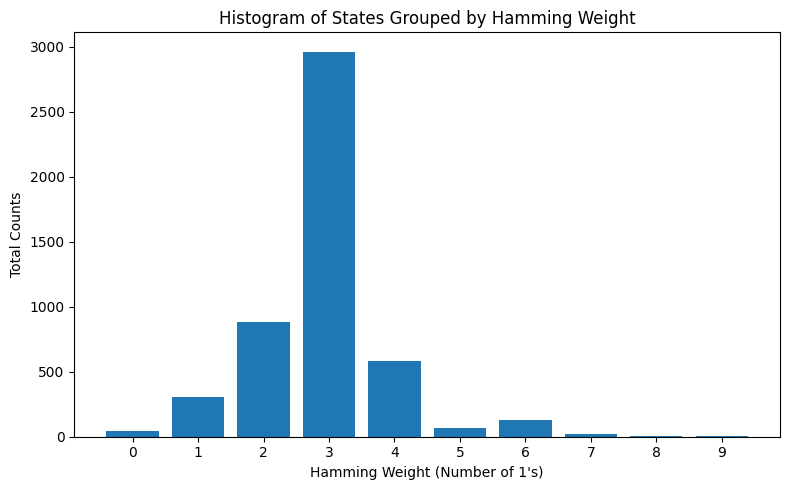

Hamming Weight 0: 000000000:43
Hamming Weight 1: 000010000:34, 000000010:39, 010000000:32, 001000000:40, 100000000:43, 000001000:27, 000000100:36, 000100000:27, 000000001:25
Hamming Weight 2: 000010010:26, 000000101:30, 100000001:22, 000000011:15, 001010000:25, 001000100:17, 110000000:25, 000011000:28, 010000010:21, 010010000:27, 000110000:17, 000100010:28, 100000100:22, 010001000:22, 011000000:32, 000100100:31, 100001000:23, 000001001:28, 001000001:24, 000010001:28, 001100000:29, 000001010:21, 000010100:29, 000101000:23, 000000110:27, 000100001:24, 001000010:32, 100010000:16, 010000001:24, 100000010:25, 100100000:24, 010100000:27, 101000000:23, 000001100:21, 010000100:22, 001001000:23
Hamming Weight 3: 000010110:29, 010100100:31, 101000010:38, 100001010:37, 001000110:37, 001001001:38, 101100000:31, 100010010:32, 001101000:41, 010010100:41, 010100001:34, 110010000:27, 001001100:41, 001010001:42, 100001100:29, 000101010:37, 010001001:35, 000011010:32, 010011000:36, 001011000:49, 0000110

In [68]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Create a mapping from Hamming weight to aggregated count and details.
hamming_data = defaultdict(lambda: {"total": 0, "states": []})
for state, count in samples_unbalanced.items():
    state_str = ''.join(map(str, state)) if isinstance(state, (tuple, list)) else state
    # Calculate Hamming weight (number of 1's).
    hamming_weight = state_str.count('1')
    hamming_data[hamming_weight]["total"] += count
    hamming_data[hamming_weight]["states"].append((state_str, count))

# Prepare data for plotting.
weights = sorted(hamming_data.keys())
totals = [hamming_data[w]["total"] for w in weights]

plt.figure(figsize=(8, 5))
plt.bar([str(w) for w in weights], totals)
plt.xlabel("Hamming Weight (Number of 1's)")
plt.ylabel("Total Counts")
plt.title("Histogram of States Grouped by Hamming Weight")
plt.tight_layout()
plt.show()

# Optionally, print the details for each group.
for w in weights:
    states_info = ', '.join([f'{st}:{cnt}' for st, cnt in hamming_data[w]["states"]])
    print(f"Hamming Weight {w}: {states_info}")


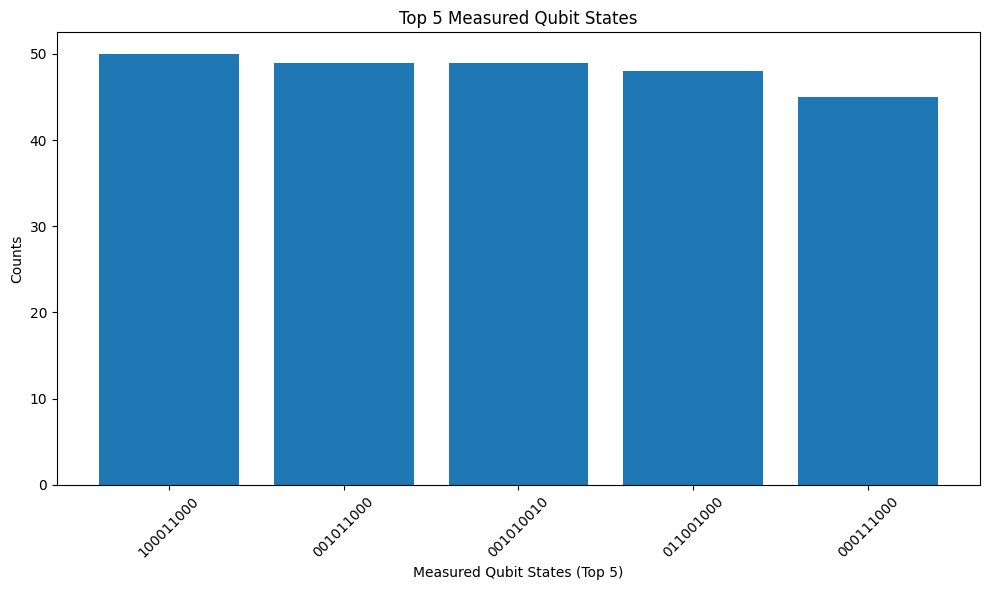

In [69]:
import matplotlib.pyplot as plt

# Define the number of top states you want to display.
k = 5  # change this value as needed

# Convert each state to a string (if necessary) for the labels.
states_str = [
    ''.join(map(str, state)) if isinstance(state, (tuple, list)) else state
    for state in samples_unbalanced.keys()
]
counts = list(samples_unbalanced.values())

# Zip the states with counts and sort them in descending order by count.
sorted_states = sorted(zip(states_str, counts), key=lambda x: x[1], reverse=True)

# Unpack the sorted list and take only the top k elements.
top_states, top_counts = zip(*sorted_states[:k])

plt.figure(figsize=(10, 6))
plt.bar(top_states, top_counts)
plt.xlabel("Measured Qubit States (Top {})".format(k))
plt.ylabel("Counts")
plt.title("Top {} Measured Qubit States".format(k))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Quantum Annealing Solution


[Quantum
annealing](https://en.wikipedia.org/wiki/Quantum_annealing#:~:text=Quantum%20annealing%20is%20used%20mainly,Apolloni%2C%20N.)
is a process that exploits quantum mechanical effects to find low energy
states of Ising Hamiltonians. We will use the quantum annealer D-Wave
Advantage, a quantum computing system developed by D-Wave Systems Inc
that has more than 5000 qubits.


In [71]:
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.cloud import Client
import dimod
import pandas as pd

bqm = {}
# BQM - Binary Quadratic Model
# This creates the QUBO model of our Knapsack problem using the slack variables approach
# offset is the constant term in our QUBO formulation
# ----------- SLACK METHOD -----------
max_nodes = 3
bqm["slack"] = dimod.BQM.from_qubo(QT, offset=lambd * max_nodes**2)
bqm["slack"].relabel_variables({i: f"x_{i}" for i in range(bqm["slack"].num_variables)})
# -----------  UNBALANCED METHOD -----------
lagrange_multiplier = [0.96, 0.0371]  # Again values from the paper
bqm["unbalanced"] = dimod.BQM.from_qubo(Q)  # This adds the objective function to the model
bqm["unbalanced"].add_linear_inequality_constraint(
    [(n, i) for n, i in enumerate(weights_list)],  # This adds the constraint
    lagrange_multiplier,
    "unbalanced",
    ub=max_nodes,
    penalization_method="unbalanced",
)
bqm["unbalanced"].relabel_variables({i: f"x_{i}" for i in range(bqm["unbalanced"].num_variables)})

# If you have an account you can execute the following code, otherwise read the file.
account = False
df = {}
if account:
    # Replace with your client information
    sampler = DWaveSampler(region="eu-central-1")
    sampler_qpu = EmbeddingComposite(sampler)
    for method in ["slack", "unbalanced"]:
        samples = sampler_qpu.sample(bqm[method], num_reads=5000)  # Executing on real hardware
        df[method] = (
            samples.to_pandas_dataframe().sort_values("energy").reset_index(drop=True)
        )  # Converting the sampling information and sort it by cost
        df[method].to_json(f"QUBO/dwave_results_{method}.json")  # save the results
else:
    df = {}
    for method in ["slack", "unbalanced"]:
        df[method] = pd.read_json(f"QUBO/dwave_results_{method}.json")
        # Loading the data from an execution on D-Wave Advantage


samples_dwave = {}
values = {}
for method in ["slack", "unbalanced"]:
    samples_dwave[method] = defaultdict(int)
    for i, row in df[method].iterrows():
        # Postprocessing the information
        sample_i = "".join(str(round(row[q])) for q in bqm[method].variables)
        samples_dwave[method][sample_i] += row["num_occurrences"]
    values[method] = {
        sum_values(sample_i, values_list): count
        for sample_i, count in samples_dwave[method].items()
        if sum_weight(sample_i, weights_list) <= max_nodes
    }

FileNotFoundError: File QUBO/dwave_results_slack.json does not exist

The histogram below shows the results of both encodings on D-Wave
Advantage. Once again, we prove that depending on the encoding method
for our problem, we get good or bad results.


In [ ]:
fig, ax = plt.subplots()
bins = {"unbalanced": 5, "slack": 40}
for method in ["unbalanced", "slack"]:
    ax.hist(
        values[method].keys(),
        weights=values[method].values(),
        bins=bins[method],
        edgecolor="black",
        label=method,
        align="right",
    )
ax.vlines(-min_cost, 0, 5000, linestyle="--", color="black", label="Optimal", linewidth=2)
ax.set_yscale("log")
ax.legend()
ax.set_ylabel("counts")
ax.set_xlabel("value")
fig.show()

# Conclusion

We have come to the end of this demo. We have covered the definition of
combinatorial optimization problems and how to formulate one of them,
the Knapsack Problem, using QUBO, and two different encodings: slack
variables and unbalanced penalization. Then, we solved them using
optimization-free QAOA and QA. Now, it's your turn to experiment with
QAOA! If you need some inspiration:

-   Look at the [OpenQAOA](https://openqaoa.entropicalabs.com/) set of
    problems. There are plenty of them like bin packing, traveling
    salesman, and maximal independent set, among others.
-   Play around with larger problems.

# References

\[1\] Farhi, E., Goldstone, J., & Gutmann, S. (2014). A Quantum
Approximate Optimization Algorithm. <http://arxiv.org/abs/1411.4028>

\[2\] Montanez-Barrera, A., Willsch, D., A., Maldonado-Romo, &
Michielsen, K. (2022). Unbalanced penalization: A new approach to encode
inequality constraints of combinatorial problems for quantum
optimization algorithms. <http://arxiv.org/abs/2211.13914>

\[3\] Montanez-Barrera, J. A., Heuvel, P. van den, Willsch, D., &
Michielsen, K. (2023). Improving Performance in Combinatorial
Optimization Problems with Inequality Constraints: An Evaluation of the
Unbalanced Penalization Method on D-Wave Advantage.
<https://doi.org/10.1109/QCE57702.2023.00067>


# About the author
